# EDA for a randomly selected user

## Load packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load random user data

In [2]:
user_number = 5
path = f"data/S{user_number:02d}_data.parquet" # input path to a parquet

df = pd.read_parquet(path)

In [3]:
df.columns

Index(['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y',
       'diameter', 'EKG', 'light', 'EDA', 'HR', 'trigger', 'valence_rating',
       'arousal_rating', 'start_timestamp', 'duration', 'norm_pos_x_fixation',
       'norm_pos_y_fixation', 'dispersion', 'confidence_fixation',
       'end_timestamp', 'user_id', 'categorised_rating',
       'fixation_duration_mean', 'fixation_duration_variance',
       'fixation_duration_skewness', 'fixation_duration_kurtosis',
       'fixation_dispersion_mean', 'fixation_dispersion_variance',
       'fixation_dispersion_skewness', 'fixation_dispersion_kurtosis',
       'fixation_position_x_mean', 'fixation_position_x_variance',
       'fixation_position_x_skewness', 'fixation_position_x_kurtosis',
       'fixation_position_y_mean', 'fixation_position_y_variance',
       'fixation_position_y_skewness', 'fixation_position_y_kurtosis',
       'pupil_diameter_mean', 'pupil_diameter_variance',
       'pupil_diameter_skewness', 'pupil_

In [4]:
df.head()

,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,EKG,light,EDA,HR,...,pupil_diameter_skewness,pupil_diameter_kurtosis,pupil_position_x_mean,pupil_position_x_variance,pupil_position_x_skewness,pupil_position_x_kurtosis,pupil_position_y_mean,pupil_position_y_variance,pupil_position_y_skewness,pupil_position_y_kurtosis
0,1970-01-01 00:01:31.460631,1,0.844470,0.546572,0.389501,17.853228,0.509102,0.028748,0.386252,76.876931,...,NaN,NaN,0.546572,NaN,NaN,NaN,0.389501,NaN,NaN,NaN
1,1970-01-01 00:01:31.464675,0,0.887404,0.528907,0.593598,19.250107,0.509102,0.028748,0.386252,76.876931,...,NaN,NaN,0.537739,0.000156,NaN,NaN,0.491549,0.020828,NaN,NaN
2,1970-01-01 00:01:31.468711,1,0.899697,0.545736,0.389690,17.390347,0.509102,0.028748,0.386252,76.876931,...,1.297412,NaN,0.540405,0.000099,-1.718359,NaN,0.457596,0.013872,1.732046e+00,NaN
3,1970-01-01 00:01:31.479027,0,0.917116,0.529443,0.593455,18.988171,0.509102,0.028748,0.386252,76.876931,...,-0.153978,-4.318457,0.537664,0.000096,0.003696,-5.948879,0.491561,0.013863,-9.555564e-07,-5.999980
4,1970-01-01 00:01:31.484675,1,0.962555,0.547391,0.389574,17.832127,0.509102,0.028748,0.386252,76.876931,...,0.418819,-2.535178,0.539610,0.000091,-0.593262,-3.297903,0.471164,0.012477,6.085799e-01,-3.333325


## Drop rows where valence or arousal is nan

In [5]:
# Drop rows where valence or arousal or trigger are NaN

df = df.dropna(subset=['valence_rating', 'arousal_rating', 'trigger'])

In [6]:
# 1) make sure ratings are numeric
df['valence_rating']  = pd.to_numeric(df['valence_rating'],  errors='coerce')
df['arousal_rating']  = pd.to_numeric(df['arousal_rating'], errors='coerce')

# 2) drop any rows that became NaN after coercion
df = df.dropna(subset=['valence_rating', 'arousal_rating', 'trigger'])

In [7]:
# valence_per_trigger = df.groupby('trigger').mean()["valence_rating"].to_frame().reset_index()

# arousal_per_trigger = df.groupby('trigger').mean()["arousal_rating"].to_frame().reset_index()

## Data filtering
### Filter data according to recommended criteria

In [8]:
original_len = len(df)

keep_mask = pd.Series(True, index=df.index)

# 1) For pupil diameter: Remove blinks (no pupil size data)
keep_mask &= df["diameter"].notna()

keep_mask.sum() / len(keep_mask)

np.float64(1.0)

In [9]:
# 2) For fixations: Filter out eye positions outside stimulus/field of view
valid_positions = (
    (df["norm_pos_x_fixation"] >= -2)
    & (df["norm_pos_x_fixation"] <= 2)
    & (df["norm_pos_y_fixation"] >= -2)
    & (df["norm_pos_y_fixation"] <= 2)
)
keep_mask &= (
    valid_positions | df["norm_pos_x_fixation"].isna()
)

keep_mask.sum() / len(keep_mask)

np.float64(1.0)

In [10]:
df["HR"].min(), df["HR"].max(), df["HR"].isna().sum()

(63.7314712696859, 106.280241156974, np.int64(0))

In [11]:
# 3) For HR: Filter out abnormal values
valid_hr = (df["HR"] <= 150) & (df["HR"] >= 50) | df["HR"].isna()
keep_mask &= valid_hr

keep_mask.sum() / len(keep_mask)

np.float64(1.0)

In [12]:
# Calculate HR jumps
hr_jumps = df["HR"].diff().abs()
keep_mask &= (hr_jumps <= 20) | hr_jumps.isna()

keep_mask.sum() / len(keep_mask)

np.float64(0.9999948411592947)

In [13]:
# 4) For EDA: Remove zero signal
keep_mask &= (df["EDA"] != 0) | df["EDA"].isna()

keep_mask.sum() / len(keep_mask)

np.float64(0.9999948411592947)

In [14]:
# Apply all filters
df_filtered = df[keep_mask]

In [15]:
print(f"Original dataset: {original_len} rows")
print(f"Filtered dataset: {len(df_filtered)} rows")
print(
    f"Removed: {original_len - len(df_filtered)} rows ({(1 - len(df_filtered) / original_len) * 100:.2f}%)"
)

Original dataset: 193842 rows
Filtered dataset: 193841 rows
Removed: 1 rows (0.00%)


In [16]:
df = df_filtered

### Valence and Arousal rating distribution

In [17]:
# now compute means per trigger on just that one column
valence_per_trigger = df.groupby('trigger')['valence_rating'].mean().reset_index()
arousal_per_trigger = df.groupby('trigger')['arousal_rating'].mean().reset_index()

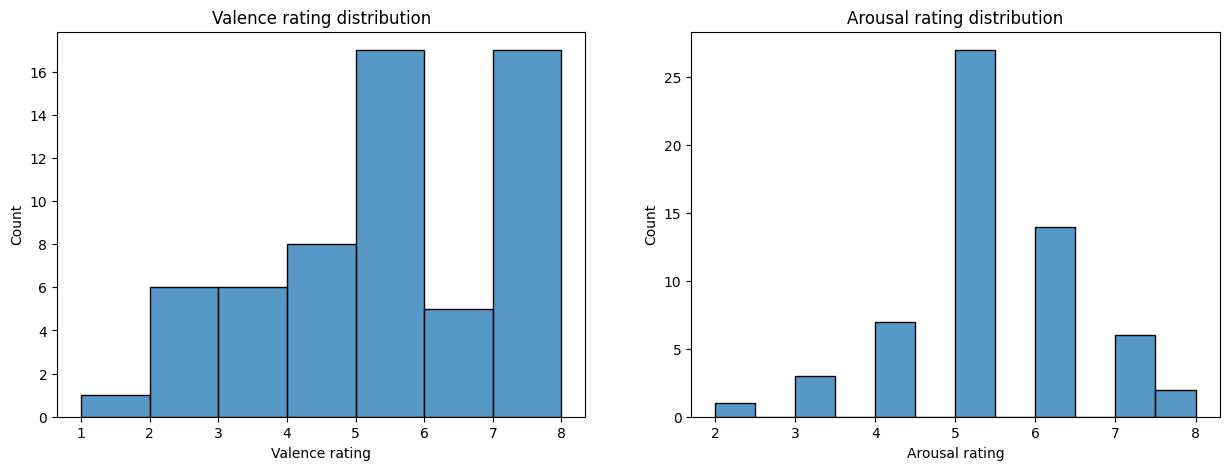

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(valence_per_trigger["valence_rating"], ax=axs[0])
axs[0].set_title("Valence rating distribution")
axs[0].set_xlabel("Valence rating")

sns.histplot(arousal_per_trigger["arousal_rating"], ax=axs[1])
axs[1].set_title("Arousal rating distribution")
axs[1].set_xlabel("Arousal rating")

plt.show()

### Bitalino in time

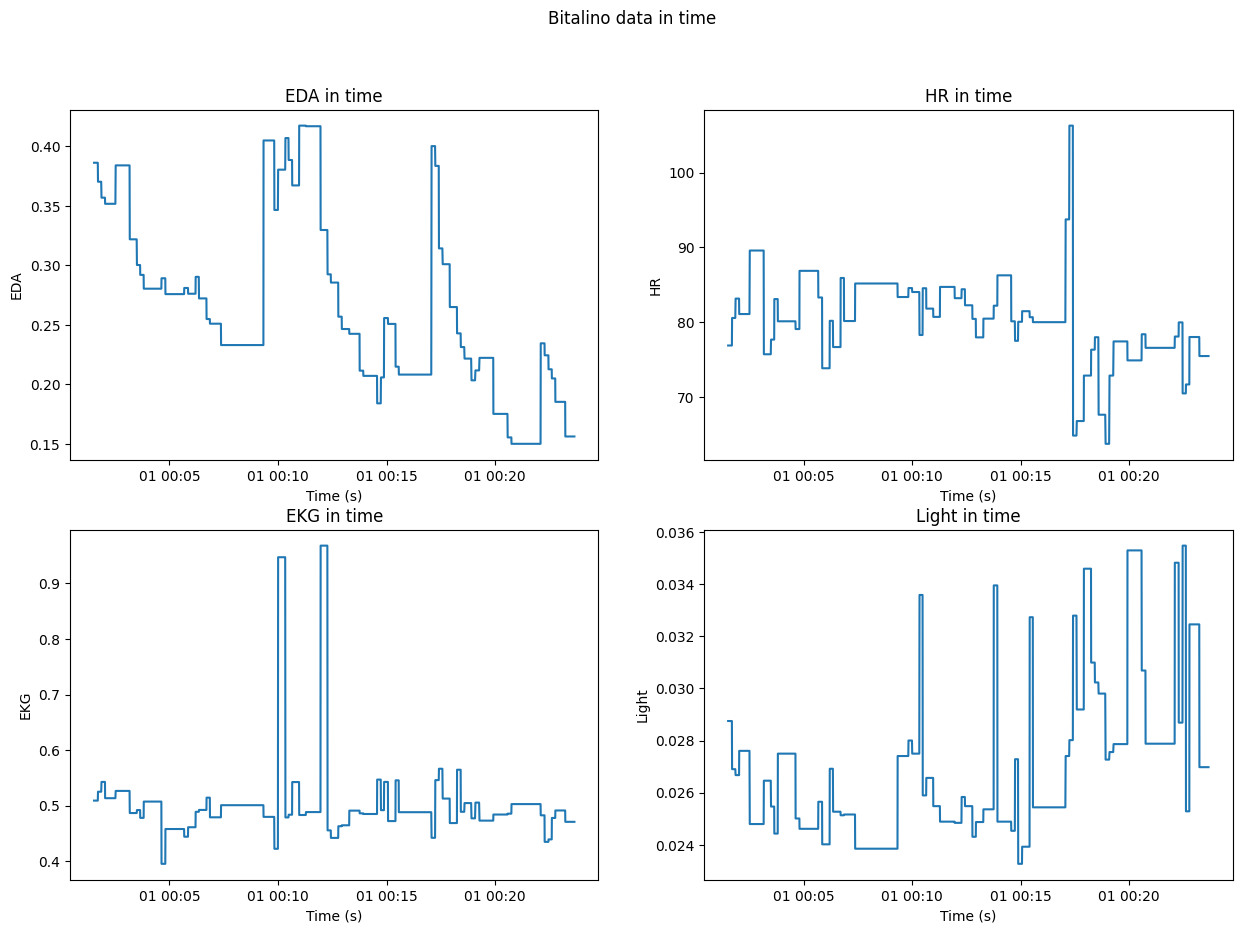

In [19]:
df_sorted = df.sort_values(by=['pupil_timestamp'])

# Get row every 100 rows in pupil_timestamp
df_sorted = df_sorted.iloc[::100, :]

# Plot EDA in time
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Bitalino data in time")

sns.lineplot(data=df_sorted, x="pupil_timestamp", y="EDA", ax=axs[0, 0])
axs[0, 0].set_title("EDA in time")
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("EDA")

sns.lineplot(data=df_sorted, x="pupil_timestamp", y="HR", ax=axs[0, 1])
axs[0, 1].set_title("HR in time")
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_ylabel("HR")

sns.lineplot(data=df_sorted, x="pupil_timestamp", y="EKG", ax=axs[1, 0])
axs[1, 0].set_title("EKG in time")
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("EKG")

sns.lineplot(data=df_sorted, x="pupil_timestamp", y="light", ax=axs[1, 1])
axs[1, 1].set_title("Light in time")
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("Light")


plt.show()

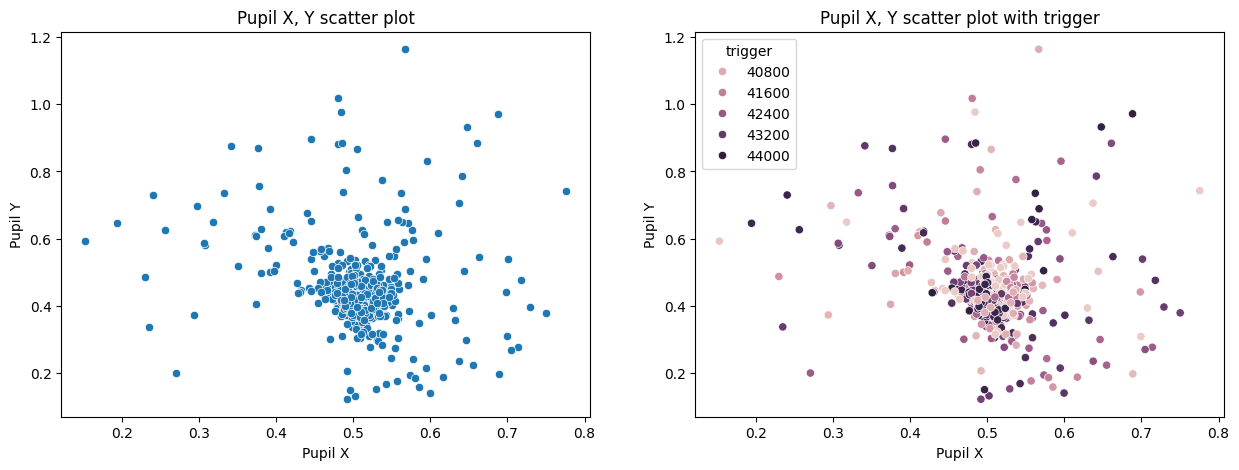

In [20]:
# X, Y of pupil scatter plot

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

df_fixated = df[df["norm_pos_y_fixation"] > 0]
sns.scatterplot(data=df_fixated[::100], x="norm_pos_x_fixation", y="norm_pos_y_fixation", ax=axs[0])
axs[0].set_title("Pupil X, Y scatter plot")
axs[0].set_xlabel("Pupil X")
axs[0].set_ylabel("Pupil Y")

sns.scatterplot(data=df_fixated[::100], x="norm_pos_x_fixation", y="norm_pos_y_fixation", hue="trigger", ax=axs[1])
axs[1].set_title("Pupil X, Y scatter plot with trigger")
axs[1].set_xlabel("Pupil X")
axs[1].set_ylabel("Pupil Y")    

plt.show()

In [21]:
df

,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter,EKG,light,EDA,HR,...,pupil_diameter_skewness,pupil_diameter_kurtosis,pupil_position_x_mean,pupil_position_x_variance,pupil_position_x_skewness,pupil_position_x_kurtosis,pupil_position_y_mean,pupil_position_y_variance,pupil_position_y_skewness,pupil_position_y_kurtosis
0,1970-01-01 00:01:31.460631,1,0.844470,0.546572,0.389501,17.853228,0.509102,0.028748,0.386252,76.876931,...,NaN,NaN,0.546572,NaN,NaN,NaN,0.389501,NaN,NaN,NaN
1,1970-01-01 00:01:31.464675,0,0.887404,0.528907,0.593598,19.250107,0.509102,0.028748,0.386252,76.876931,...,NaN,NaN,0.537739,0.000156,NaN,NaN,0.491549,0.020828,NaN,NaN
2,1970-01-01 00:01:31.468711,1,0.899697,0.545736,0.389690,17.390347,0.509102,0.028748,0.386252,76.876931,...,1.297412,NaN,0.540405,0.000099,-1.718359,NaN,0.457596,0.013872,1.732046e+00,NaN
3,1970-01-01 00:01:31.479027,0,0.917116,0.529443,0.593455,18.988171,0.509102,0.028748,0.386252,76.876931,...,-0.153978,-4.318457,0.537664,0.000096,0.003696,-5.948879,0.491561,0.013863,-9.555564e-07,-5.999980
4,1970-01-01 00:01:31.484675,1,0.962555,0.547391,0.389574,17.832127,0.509102,0.028748,0.386252,76.876931,...,0.418819,-2.535178,0.539610,0.000091,-0.593262,-3.297903,0.471164,0.012477,6.085799e-01,-3.333325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193837,1970-01-01 00:23:39.535358,1,1.000000,0.553491,0.392653,16.141836,0.470893,0.026978,0.156222,75.467227,...,-0.231938,-0.657654,0.521479,0.000830,-0.191385,0.161373,0.507506,0.013106,-2.774807e-01,-1.762985
193838,1970-01-01 00:23:39.543296,1,0.863678,0.551677,0.393144,16.490908,0.470893,0.026978,0.156222,75.467227,...,-0.230756,-0.656772,0.521501,0.000832,-0.192152,0.153576,0.507409,0.013105,-2.755626e-01,-1.763764
193839,1970-01-01 00:23:39.543297,0,0.993420,0.529760,0.594706,15.373764,0.470893,0.026978,0.156222,75.467227,...,-0.231359,-0.654103,0.521510,0.000831,-0.193169,0.156780,0.507506,0.013099,-2.775123e-01,-1.762661
193840,1970-01-01 00:23:39.551361,0,0.937060,0.528806,0.595481,15.357680,0.470893,0.026978,0.156222,75.467227,...,-0.230871,-0.649520,0.521522,0.000831,-0.194285,0.156688,0.507492,0.013097,-2.774788e-01,-1.762568


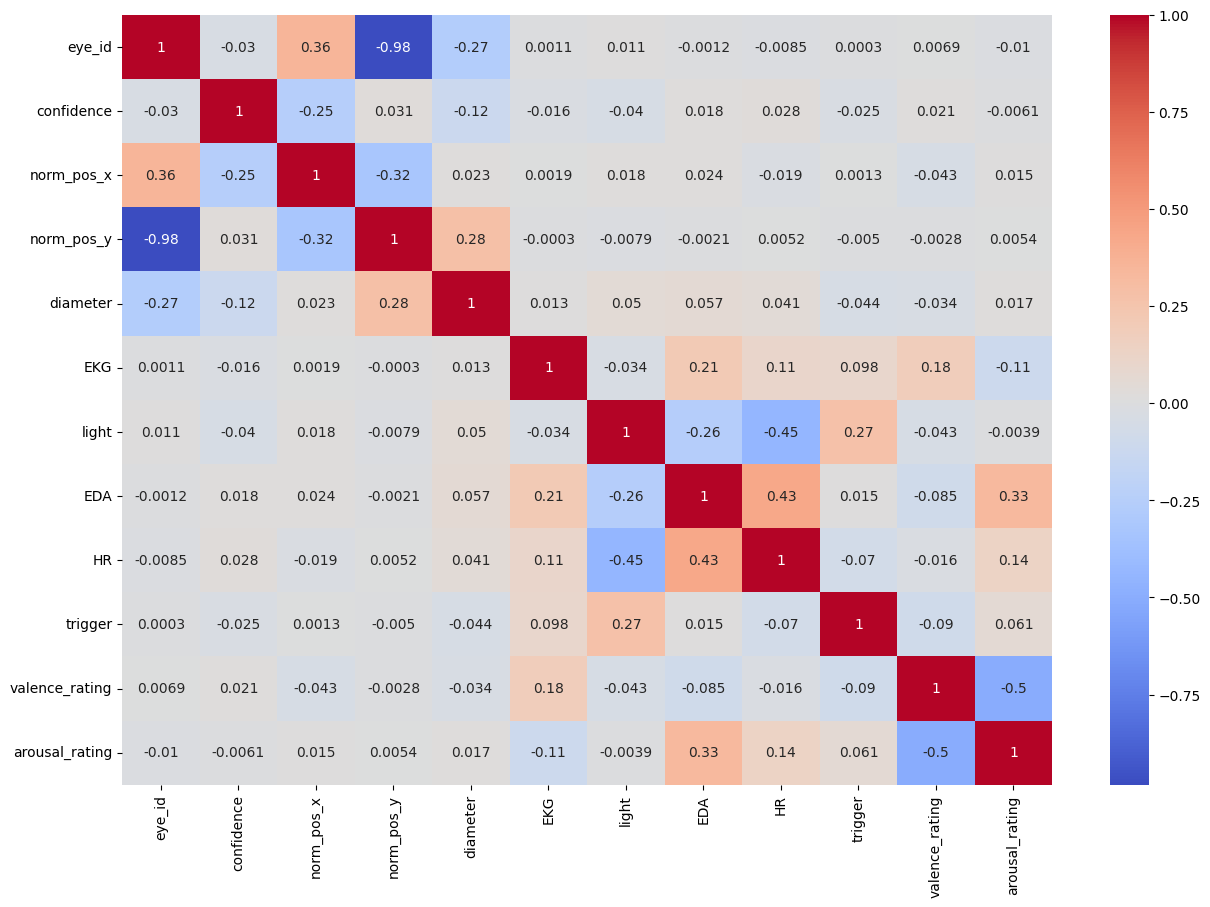

In [22]:
# Print correlation matrix

columns_of_interest = ["pupil_timestamp", "eye_id", "confidence", "norm_pos_x", "norm_pos_y", "diameter", "EKG", "light", "EDA", "HR", "trigger", "valence_rating", "arousal_rating"]
corr = df[columns_of_interest].corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, annot=True, ax=ax, cmap="coolwarm")
plt.show()

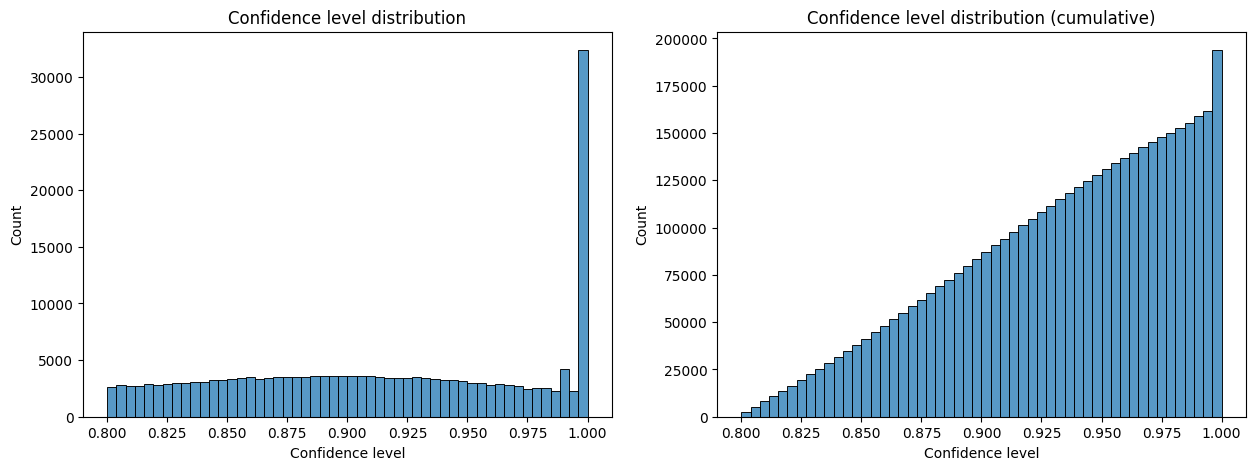

In [23]:
# Confidence level distribution

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df["confidence"], ax=axs[0])
axs[0].set_title("Confidence level distribution")
axs[0].set_xlabel("Confidence level")

sns.histplot(df["confidence"], ax=axs[1], cumulative=True)
axs[1].set_title("Confidence level distribution (cumulative)")
axs[1].set_xlabel("Confidence level")

plt.show()

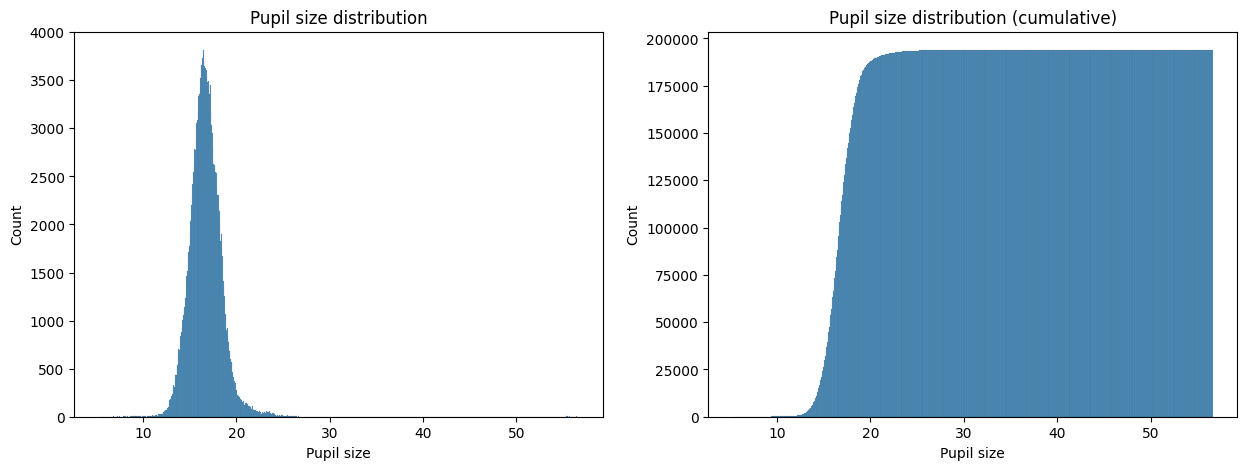

In [24]:
# Pupil size distribution

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df["diameter"], ax=axs[0])
axs[0].set_title("Pupil size distribution")
axs[0].set_xlabel("Pupil size")

sns.histplot(df["diameter"], ax=axs[1], cumulative=True)
axs[1].set_title("Pupil size distribution (cumulative)")
axs[1].set_xlabel("Pupil size")

plt.show()

## Scatter plots of Arousal vs Bitalino data

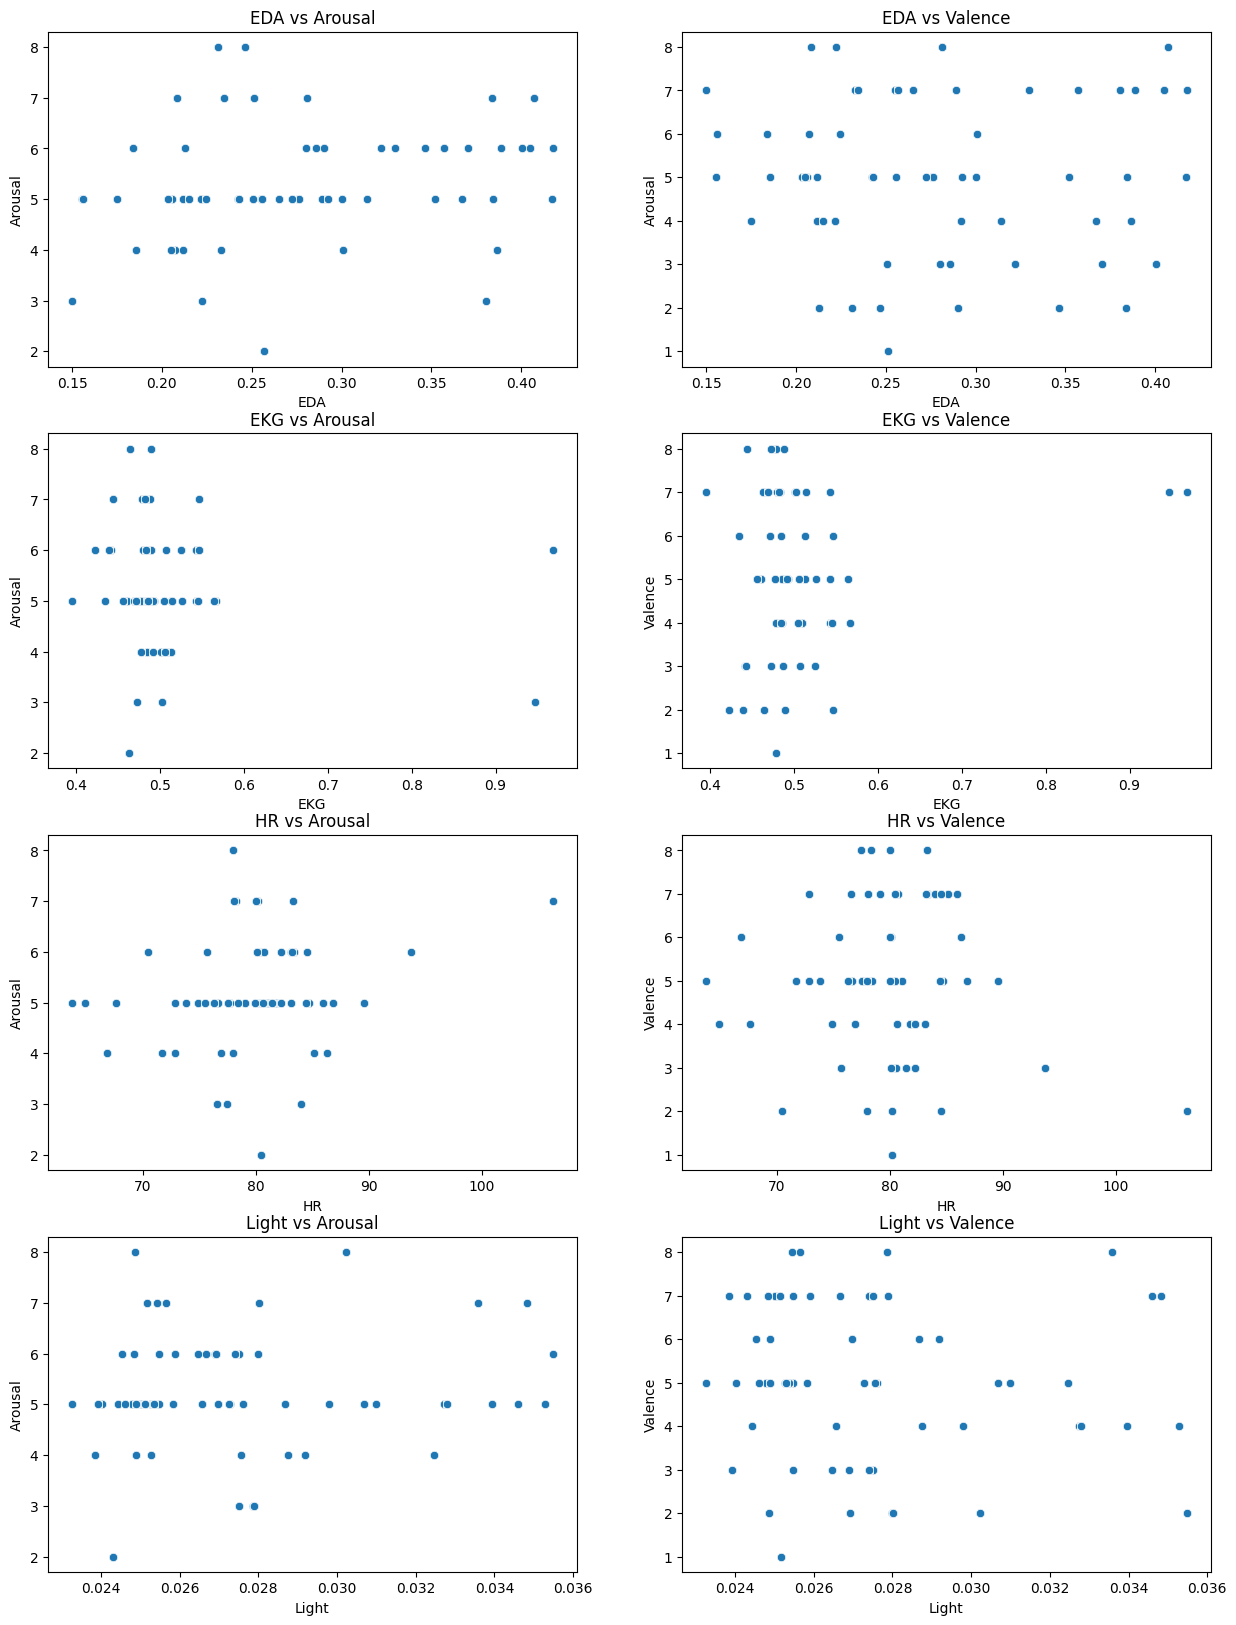

In [25]:
# Arousal vs EDA, EKG, HR, light

fig, axs = plt.subplots(4, 2, figsize=(15, 20))

sns.scatterplot(data=df, x="EDA", y="arousal_rating", ax=axs[0, 0])
axs[0, 0].set_title("EDA vs Arousal")
axs[0, 0].set_xlabel("EDA")
axs[0, 0].set_ylabel("Arousal")

sns.scatterplot(data=df, x="EDA", y="valence_rating", ax=axs[0, 1])
axs[0, 1].set_title("EDA vs Valence")
axs[0, 1].set_xlabel("EDA")
axs[0, 1].set_ylabel("Arousal")

sns.scatterplot(data=df, x="EKG", y="arousal_rating", ax=axs[1, 0])
axs[1, 0].set_title("EKG vs Arousal")
axs[1, 0].set_xlabel("EKG")
axs[1, 0].set_ylabel("Arousal")

sns.scatterplot(data=df, x="EKG", y="valence_rating", ax=axs[1, 1])
axs[1, 1].set_title("EKG vs Valence")
axs[1, 1].set_xlabel("EKG")
axs[1, 1].set_ylabel("Valence")

sns.scatterplot(data=df, x="HR", y="arousal_rating", ax=axs[2, 0])
axs[2, 0].set_title("HR vs Arousal")
axs[2, 0].set_xlabel("HR")
axs[2, 0].set_ylabel("Arousal")

sns.scatterplot(data=df, x="HR", y="valence_rating", ax=axs[2, 1])
axs[2, 1].set_title("HR vs Valence")
axs[2, 1].set_xlabel("HR")
axs[2, 1].set_ylabel("Valence")

sns.scatterplot(data=df, x="light", y="arousal_rating", ax=axs[3, 0])
axs[3, 0].set_title("Light vs Arousal")
axs[3, 0].set_xlabel("Light")
axs[3, 0].set_ylabel("Arousal")

sns.scatterplot(data=df, x="light", y="valence_rating", ax=axs[3, 1])
axs[3, 1].set_title("Light vs Valence")
axs[3, 1].set_xlabel("Light")
axs[3, 1].set_ylabel("Valence")

plt.show()


In [26]:
df.shape

(193841, 50)